# Calculate solar energy potential from solar radiation and temperature

Use method in van der Wiel et al (2019): https://www.sciencedirect.com/science/article/pii/S1364032119302862#sec3

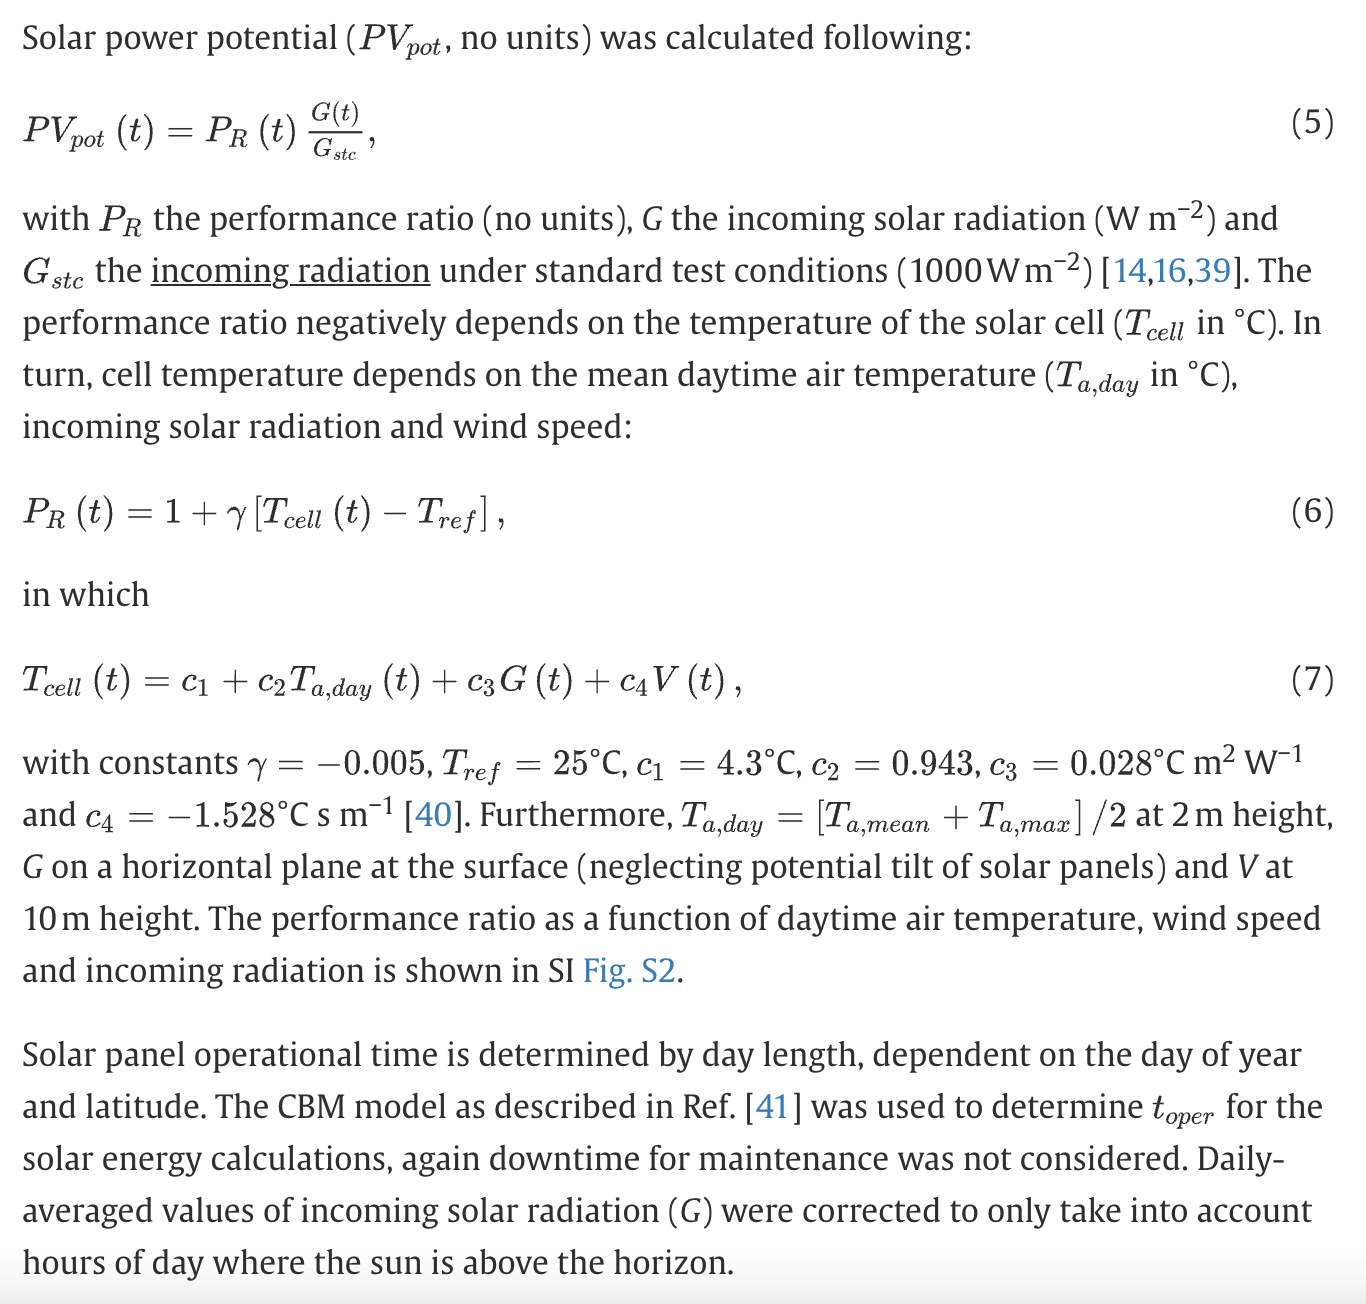

Except adapt for hourly data, replace daytime temperature with hourly temperature.

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [50]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "02:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38309 instead
  warnings.warn(


In [51]:
cluster.scale(jobs=1)
client = Client(cluster)

In [52]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/38309/status,
Dashboard: /proxy/38309/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.6:39653,Workers: 0
Dashboard: /proxy/38309/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [53]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [6]:
# %cd /g/data/w42/dr6273/work/energy_climate_modes

# import functions as fn

In [7]:
# %load_ext autoreload
# %autoreload 2

In [8]:
root_path = "/g/data/rt52/era5/single-levels/reanalysis/"

# Compute capacity factor

In [9]:
def cell_temperature(T, G, V):
    """
    Calculates solar cell temperature.
    
    T: daytime temperature or hourly temperature (deg C)
    G: incoming solar radiation (W/m^2)
    V: wind speed at 10 m (m/s)
    """
    c1 = 4.3 # deg C
    c2 = 0.943
    c3 = 0.028 # deg C m^2 / W
    c4 = -1.528 # deg C s / m
    
    return c1 + (c2 * T) + (c3 * G) + (c4 * V)

In [10]:
def performance_ratio(T_cell):
    """
    Calculate performance ratio (unitless).
    
    T_cell: cell temperature (deg C)
    """
    T_ref = 25 # reference temperature (deg C)
    gamma = -0.005 # constant
    
    return  1 + gamma * (T_cell - T_ref)

In [11]:
def PV_potential(G, V, T, compute_cell_T=True):
    """
    Calculate solar power potential (unitless)
    
    G: solar radiation (W/m^2)
    V: wind speed (m/s)
    T: mean hourly temperature (deg C)
    compute_cell_T: bool, whether to compute cell temperature or just use T
    """
    if compute_cell_T:
        T_cell = cell_temperature(T, G, V)
    else:
        T_cell = T
    P_R = performance_ratio(T_cell)
    
    G_stc = 1000 # incoming radiation under standard test conditions (1000 W/m^2)
    
    return P_R * G / G_stc

In [12]:
def windspeed(u, v):
    """
    Compute windspeed from u and v
    
    u: array of zonal wind
    v: array of meridional wind
    """
    return np.sqrt(u ** 2 + v ** 2)

In [13]:
def load_hourly(preprocess, variable, year, data_path=root_path):
    """
    Load and preprocess hourly data for a given year
    
    preprocess: preprocess function
    variable: name of variable to process
    year: year to process
    data_path: path to hourly data
    """
    # Open all hours in the year (~33 GB)
    hourly = xr.open_mfdataset(
        data_path + variable + "/" + str(year) + "/*.nc",
        preprocess=preprocess
    )
    return hourly

In [14]:
def preprocess(ds):
    """
    Preprocess function for open_mfdataset.
    Selects Australian region and renames coords.
    """
    ds = ds.sel(
        longitude=slice(aus_region[0], aus_region[1]),
        latitude=slice(aus_region[2], aus_region[3])
    )
    ds = ds.rename(
        {'longitude': 'lon',
         'latitude': 'lat'}
    )
    ds = ds.chunk({"time": -1, "lat": -1, "lon": -1})
    return ds

In [54]:
years = range(1940, 2024)

In [16]:
aus_region = [110, 155, -10, -45]

In [17]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/capacity_factor/van_der_Wiel"

In [ ]:
for year in years:
    if year % 5 == 0:
        print(year)
        
    # Wind speed 10m
    u10 = load_hourly(
        preprocess,
        "10u",
        year
    )

    v10 = load_hourly(
        preprocess,
        "10v",
        year
    )
    
    w10 = windspeed(
        u10.rename({"u10": "w10"}),
        v10.rename({"v10": "w10"})
    )["w10"]
    
    # Solar radiation
    rad = load_hourly(
        preprocess,
        "msdwswrf",
        year
    )["msdwswrf"]
    
    # Temperature
    t = load_hourly(
        preprocess,
        "2t",
        year
    )["t2m"]
    t = t - 273.15
    
    # Capacity factor
    cf = PV_potential(rad, w10, t)
    
    cf = cf.chunk({"lat": 50, "lon": 100, "time": -1})
    cf = cf.to_dataset(name="capacity_factor")
    
    encoding = {
        "capacity_factor": {"dtype": "float32"}
    }
    cf.to_netcdf(
        write_path + "/solar_capacity_factor_van_der_Wiel_era5_hourly_" + str(year) + "_Aus.nc",
        mode="w",
        encoding=encoding
    )

1940


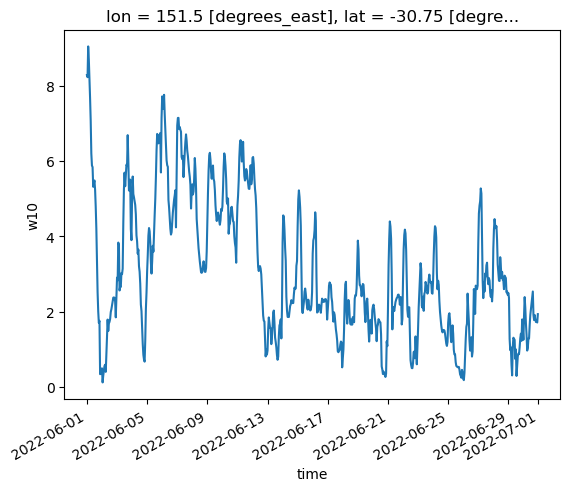

In [29]:
w = w10.sel(lon=151.5, lat=-30.75, time="2022-06").compute()
w.plot()

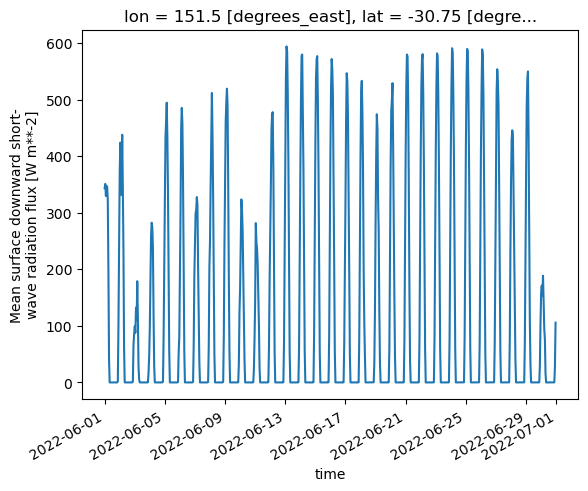

In [30]:
r = rad.sel(lon=151.5, lat=-30.75, time="2022-06").compute()
r.plot()

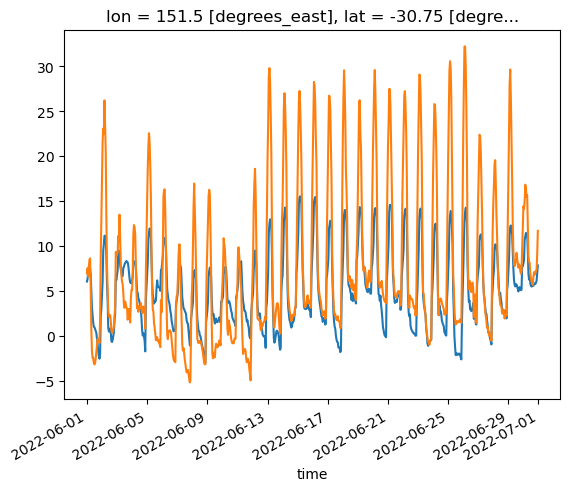

In [34]:
t_ = t.sel(lon=151.5, lat=-30.75, time="2022-06").compute()
t_.plot()
cell_temperature(t_, r, w).plot()

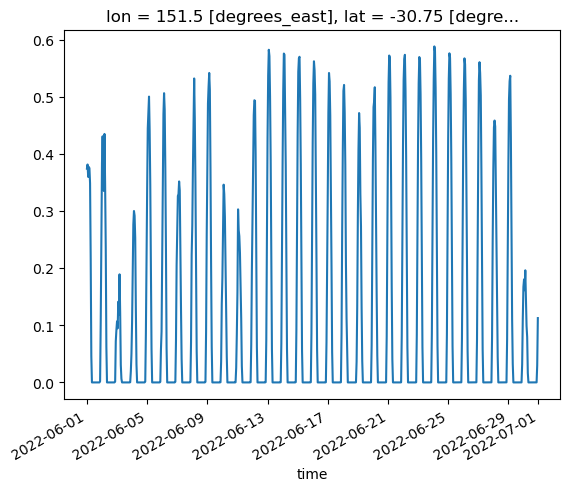

In [40]:
c = cf.sel(lon=151.5, lat=-30.75, time="2022-06").compute()
c.plot()

### Performance ratio

For radiation of 100 W/m^2, as a function of daytime temperature and wind speed.

Trying to replicate fig S2 from: https://ars.els-cdn.com/content/image/1-s2.0-S1364032119302862-mmc1.pdf

In [88]:
dummy_t = np.linspace(-10, 40, 100)
dummy_w = np.linspace(0, 25, 100)

In [94]:
P_R = np.empty((100, 100))

In [95]:
for i,w in enumerate(dummy_w):
    for j, t in enumerate(dummy_t):
        T_cell = cell_temperature(t, 400, w)
        P_R[i, j] = performance_ratio(T_cell)

In [ ]:
P_R = xr.DataArray(
    P_R.transpose(),
    dims = ['cell_T [deg C]', 'W [m/s]'],
    coords = {'T': dummy_t, 'W': dummy_w}
)

In [ ]:
P_R.plot.contourf()

# Close cluster

In [43]:
client.close()
cluster.close()